# Bayesian Optimization

We can take advantage of the previous method by using it to optimize controls in an experiment. This procedure is called Bayesian Optimization: we collect data and calculate a metric indicating how good the current setup is. We then fit a function using a Gaussian Process to identify how this quality metric behaves as a function of the parameters we actually control. From this fit we may find the optimum of the quality function and shift our control parameters there.

When collecting data points with several inputs in a system is very time-consuming, this methodology is particularly powerful, since it allows one to reach the optimum very fast.

Here we will create an example function that we want to maximize, but we assume that collecting the value of the function in each point is very time-consuming or resource-intensive and therefore we would like to find the maximum of that function with very few attempts. The same logic would work for finding the minimum of a function.

Let us start by importing some modules and creating an example function for us to maximize.


In [1]:
# Needed in Google Colab, since it does not have gpytorch by default
#!pip install gpytorch torch botorch

In [2]:
from typing import List, Tuple, Optional

import numpy as np

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import matplotlib.pyplot as plt

import torch
import gpytorch

from botorch.acquisition import UpperConfidenceBound
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.models import SingleTaskGP
from torch import Tensor
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.kernels.rbf_kernel import RBFKernel
from gpytorch.mlls import ExactMarginalLogLikelihood

/home/daniloefl/workspace/ml-lecture-oct-2023/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def true_f(x: Tensor) -> Tensor:
    """Function that we would like to optimize. Usually we do not know this!"""
    return ((torch.sin(2*np.pi*x) + torch.sin(2*np.pi*2*x))*torch.exp(-x**2/2.0/0.2)).sum(1, keepdims=True)

We can now plot this function to see how it looks like. Usually, this is very hard to do, since we have many parameter dimensions. In this example, we have a single parameter dimension to makes things easy to visualize.

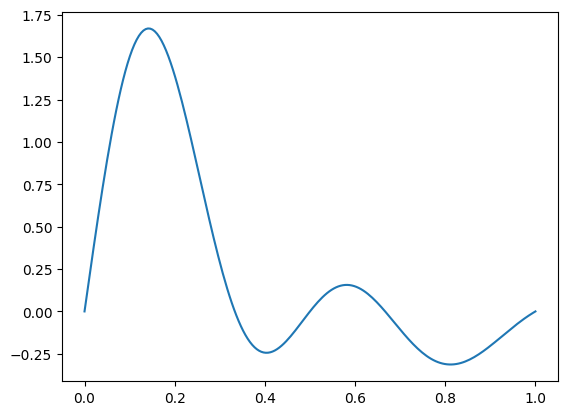

In [4]:
x_axis = torch.from_numpy(np.linspace(0.0, 1.0, 200)).unsqueeze(1)
y_axis = true_f(x_axis).detach()
plt.plot(x_axis.numpy()[:,0], y_axis.numpy())

We are now going to pretend we can only take a few points of this curve, because each time we "measure" the value of the function for a given x-axis value, it takes a lot of our resources.

To this end, we start by taking 5 points at random from the curve to make an initial fit.

In [5]:
def initial_data(n: int=5) -> Tensor:
    """Randomly select some points to test f on."""
    rng = RandomState(MT19937(SeedSequence(123456789)))
    return 0.2+torch.from_numpy(rng.rand(n, 1)*0.3).double()
    
x0 = initial_data(n=5)
y0 = true_f(x0)

Let's now plot it to visualize it, but let's make the plot a bit more detailed than before:

In [6]:
def plot_simple(x: Tensor, y: Tensor):
    """
    Plot the observed x, y and the true function.
    """
    # get a set of x-axis points from 0 to 1 for plotting
    x_axis = torch.from_numpy(np.linspace(0.0, 1.0, 200)).double().unsqueeze(1)
    
    # get the true function value
    true_y = true_f(x_axis)

    f, ax = plt.subplots(1, 1, figsize=(12, 4))

    # first the true function so we can compare things with it
    ax.plot(x_axis, true_y, 'g--', label=r"True $f$", lw=2)

    # plot the actual points we collected
    ax.plot(x.cpu().numpy()[:,0], y.cpu().numpy(), 'k^', label="Observation", markersize=8)

    # make the plot look pretty
    ax.set(xlabel="$x$", ylabel=r"$f(x)$", title="", xlim=(0.0, 1.0))
    ax.legend(loc='upper left', frameon=False, bbox_to_anchor=(1.0,1), borderaxespad=0)

    # prettify
    plt.tight_layout()
    plt.subplots_adjust(right=0.80,
                        top=0.99)

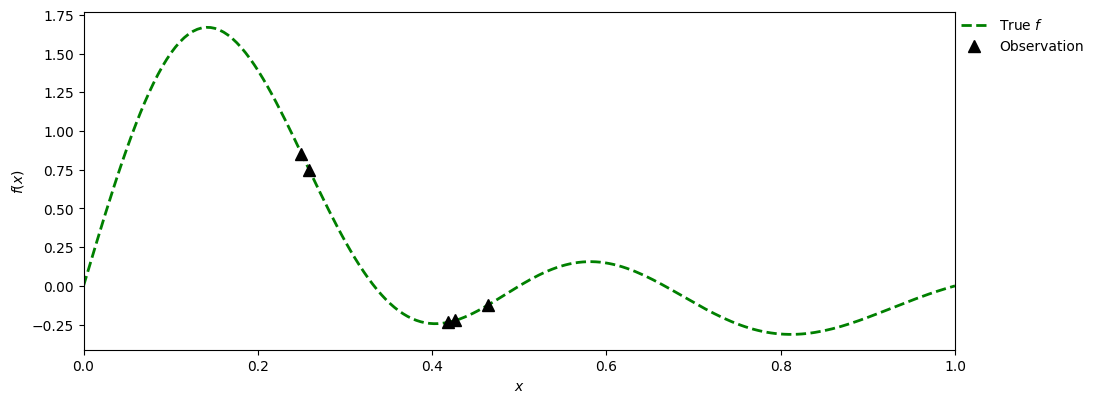

In [7]:
plot_simple(x0, y0)

So, now we have some initial points. We are assuming the true function is not known, so how can we fit those points to make this curve?
Let us create a fit model using a Gaussian Process. We create an object to do some preprocessing and hold the most important fit elements in the `FitModel` class.
Check the `botorch` documentation for more information.

In [8]:
class FitModel(SingleTaskGP):
    """Model to fit the function using the few points we know.

    Args:
      x_train: The parameters we control. Assumed of shape (B, K), where B is the number of points and K is the dimension of the data.
      y_train: The function value. Assumed of shape (B, 1), containing a single value per point.
    """
    def __init__(self, x_train: Tensor, y_train: Tensor):
        assert len(x_train.shape) == 2
        assert len(y_train.shape) == 2

        # calculate the mean and root-mean-squared error to standardize the input data
        self.x = x_train.detach()
        self.y = y_train.detach()
        self.mx = self.x.mean(dim=-2, keepdim=True)
        self.sx = torch.clamp(self.x.std(dim=-2, keepdim=True), min=1e-6)
        self.my = self.y.mean(dim=-2, keepdim=True)
        self.sy = torch.clamp(self.y.std(dim=-2, keepdim=True), min=1e-6)

        # the input data after some preprocessing
        self.x_tr = self.transform_x(self.x)
        self.y_tr = self.transform_y(self.y)

        # representation of the covariance model
        # this is the core of the model and it encodes a covariance function C(x1, x2) = S*exp(-|x2 - x1|^2/L^2)
        # S encoded using the `ScaleKernel` object
        # L is encoded using the `RBFKernel` object and it is called the lengthscale
        covar_module = ScaleKernel(RBFKernel())

        super(FitModel, self).__init__(self.x_tr, self.y_tr, covar_module=covar_module)
        self.best_y_tr = torch.max(self.y_tr)

    def transform_x(self, x: Tensor) -> Tensor:
        """Transform inputs."""
        x_tr = (x - self.mx)/self.sx
        return x_tr

    def transform_y(self, y: Tensor) -> Tensor:
        """Transform outputs."""
        y_tr = (y - self.my)/self.sy
        return y_tr

    def untransform_x(self, x: Tensor, no_constant: bool=False) -> Tensor:
        """Undo transform of inputs."""
        x_tr = x*self.sx
        if not no_constant:
            x_tr += self.mx
        return x_tr

    def untransform_y(self, y: Tensor, no_constant: bool=False) -> Tensor:
        """Undo transform of outputs."""
        y_tr = y*self.sy
        if not no_constant:
            y_tr += self.my
        return y_tr

    def predict(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        """Predict the posterior mean and uncertainty.

        Args:
          x: Input parameters

        Returns: The mean and uncertainty prediction.
        """
        x_tr = self.transform_x(x)
        pred = self.likelihood(self(x_tr))
        m = self.untransform_y(pred.mean)
        s = self.untransform_y(torch.sqrt(pred.variance), no_constant=True)
        return m, s

    def get_acquisition(self):
        """Get the acquisition function."""
        posterior_transform = ScalarizedPosteriorTransform(weights=self.sy.view(-1), offset=self.my.item())
        UCB = UpperConfidenceBound(model=self, beta=0.1, posterior_transform=posterior_transform)
        return UCB

Let's also write down a function to make the fit using the initial data and from the fit, extract what is the next candidate to be probed:

In [9]:
def update_params(x: Tensor, y: Tensor) -> Tuple[Tensor, FitModel]:
    """
    Given some input past parameters and the value of the function, get me a new value to probe.
    """
    # create a fit object
    model = FitModel(x, y)
    # get the log-likelihood for it
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    # make the fit of the model to the observed data
    opt_mll = fit_gpytorch_model(mll)

    # get the acquisition function
    acq = model.get_acquisition()

    # only focus in the bounded region [0, 1]
    d_min = torch.zeros((1, x.shape[-1]))
    d_max = torch.ones((1, x.shape[-1]))
    # transform it
    d_min_tr = model.transform_x(d_min)
    d_max_tr = model.transform_x(d_max)
    bounds = torch.cat([d_min_tr, d_max_tr], dim=0)

    # find the maximum of the acquisition function
    next_parameter, _ = optimize_acqf(
                    acq_function=acq,
                    bounds=bounds,
                    q=1,
                    num_restarts=10,
                    raw_samples=512,
                    )
    # transform the proposed result back to the original space
    next_parameter = model.untransform_x(next_parameter)
    # return the parameter and the fit result, in case we want to plot it
    return next_parameter, model


Finally, let's make an auxiliary plot function to show what is happening:

In [10]:
def plot(x: Tensor, y: Tensor, model: FitModel):
    """
    Plot the observed x and y, and the fit result.
    """
    # get a set of x-axis points from 0 to 1 for plotting
    x_axis = torch.from_numpy(np.linspace(0.0, 1.0, 200)).double().unsqueeze(1)
    
    # get the true function value
    true_y = true_f(x_axis)
    
    # get the prediction from the fit
    m, s = model.predict(x_axis)
    
    # get the value of the acquisition function:
    ei = model.get_acquisition()(model.transform_x(x_axis).unsqueeze(1))
    
    # transform the results into numpy objects and drop the extra dimension if needed
    m = m.detach().cpu().numpy()[0,:]
    s = s.detach().cpu().numpy()[0,:]
    true_y = true_y.detach().cpu().numpy()
    ei = ei.detach().cpu().numpy()
    x_axis = x_axis.cpu().numpy()[:,0]
    
    # plot it
    f, ax = plt.subplots(2, 1, figsize=(12, 8))

    # first the true function so we can compare things with it
    ax[0].plot(x_axis, true_y, 'g--', label=r"True $f$", lw=2)
    # now the fit result
    ax[0].plot(x_axis, m, 'b-', label="Mean", lw=2)
    # now the uncertainty of the fit
    ax[0].fill_between(x_axis, (m - 1*s), (m + 1*s), alpha=0.3, label="68% CL")

    # plot the actual points we collected
    ax[0].plot(x.cpu().numpy()[:,0], y.cpu().numpy(), 'k^', label="Observation", markersize=8)

    # highlight the last point we collected
    ax[0].plot(x.cpu().numpy()[-1:, 0], y.cpu().numpy()[-1:], 'ro', label="Last observation", markersize=10)

    # make the plot look pretty
    ax[0].set(xlabel="", ylabel=r"$f(x)$", title="", xlim=(0.0, 1.0))
    ax[0].set_xticks([])
    ax[0].legend(loc='upper left', frameon=False, bbox_to_anchor=(1.0,1), borderaxespad=0)

    # now show the acquision function in the bottom plot
    ax[1].plot(x_axis, ei, 'k-', lw=2, label=r"$\mathcal{A}$")
    ax[1].set(xlabel=r"$x$", ylabel=r"Acquisition function", title="", xlim=(0.0, 1.0))

    # find the maximum of the acquision function and show some dotted lines to indicate it in both plots
    idx_next = np.argmax(ei)
    x_next = x_axis[idx_next]
    ax[1].axvline(x_next, 0, 1, c='r', ls=':', lw=2, label=r"Next $\vec{x}$")
    ax[0].axvline(x_next, 0, 1, c='r', ls=':', lw=2)
    ax[1].legend(loc='upper left', frameon=False, bbox_to_anchor=(1.0,1), borderaxespad=0)

    # prettify
    plt.tight_layout()
    plt.subplots_adjust(
                        #left=0.05,
                        #bottom=0.05,
                        right=0.80,
                        top=0.99,
                        #wspace=0.4,
                        hspace=0
                        )

Now, let's use the initial x and y values to make the fit itself:

In [11]:
next_parameter, model = update_params(x0, y0)

/home/daniloefl/workspace/ml-lecture-oct-2023/env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


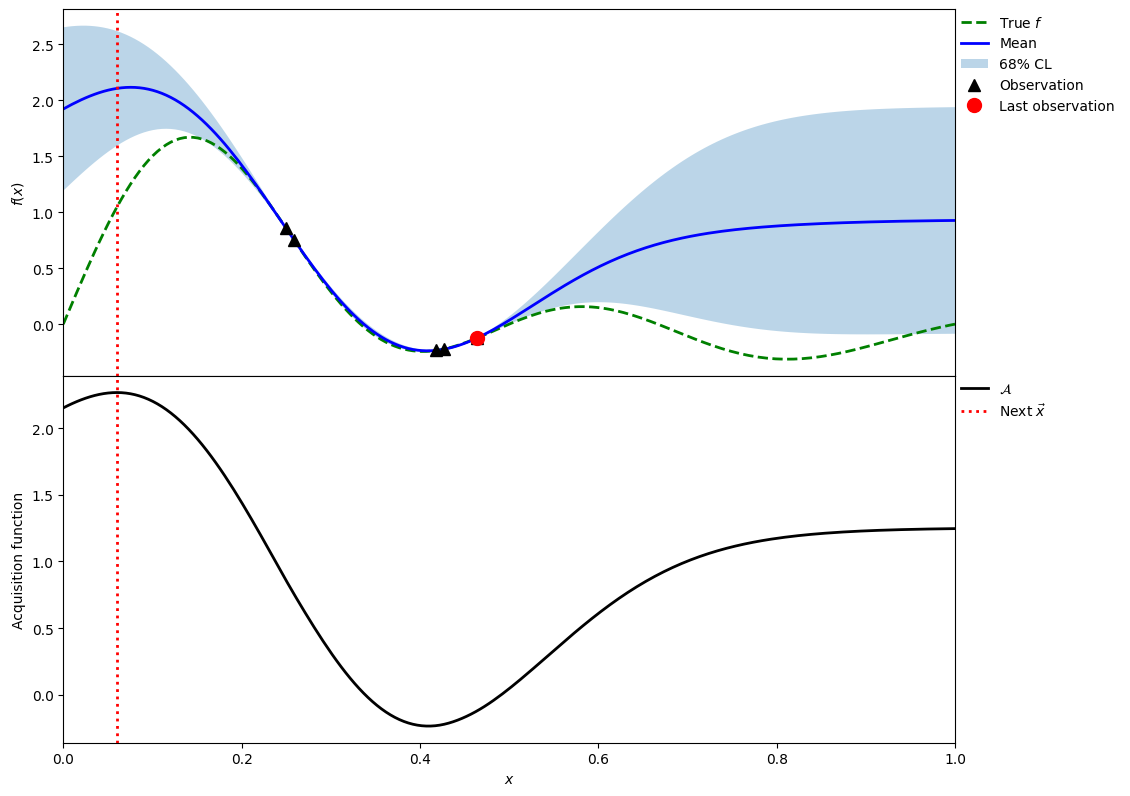

In [12]:
plot(x0, y0, model)

Notice that the model fit is quite close to the actual fit function. We didn't have to guess the actual function shape itself. The uncertainty band is also calculated and the maximum of the acquisition function, calculated using the fit result gives us the next point to probe.

Let's probe the next point x in the `next_parameter` and add it to our table of values known. After that we can just repeat the process above.

In [13]:
next_y = true_f(next_parameter)

x1 = torch.cat([x0, next_parameter], axis=0)
y1 = torch.cat([y0, next_y], axis=0)

In [14]:
next_parameter, model = update_params(x1, y1)

/home/daniloefl/workspace/ml-lecture-oct-2023/env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


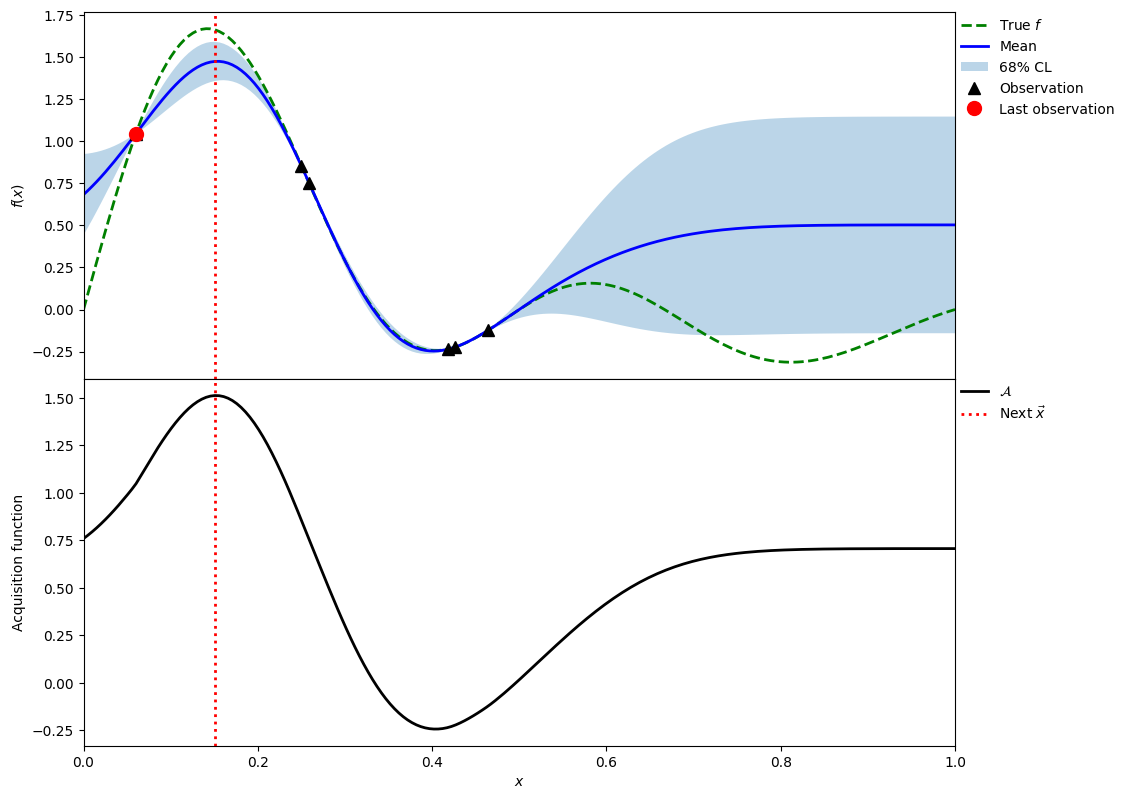

In [14]:
plot(x1, y1, model)

This can be repeated many times until we are very confident we are close enough to the maximum:

/home/daniloefl/workspace/ml-lecture-oct-2023/env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


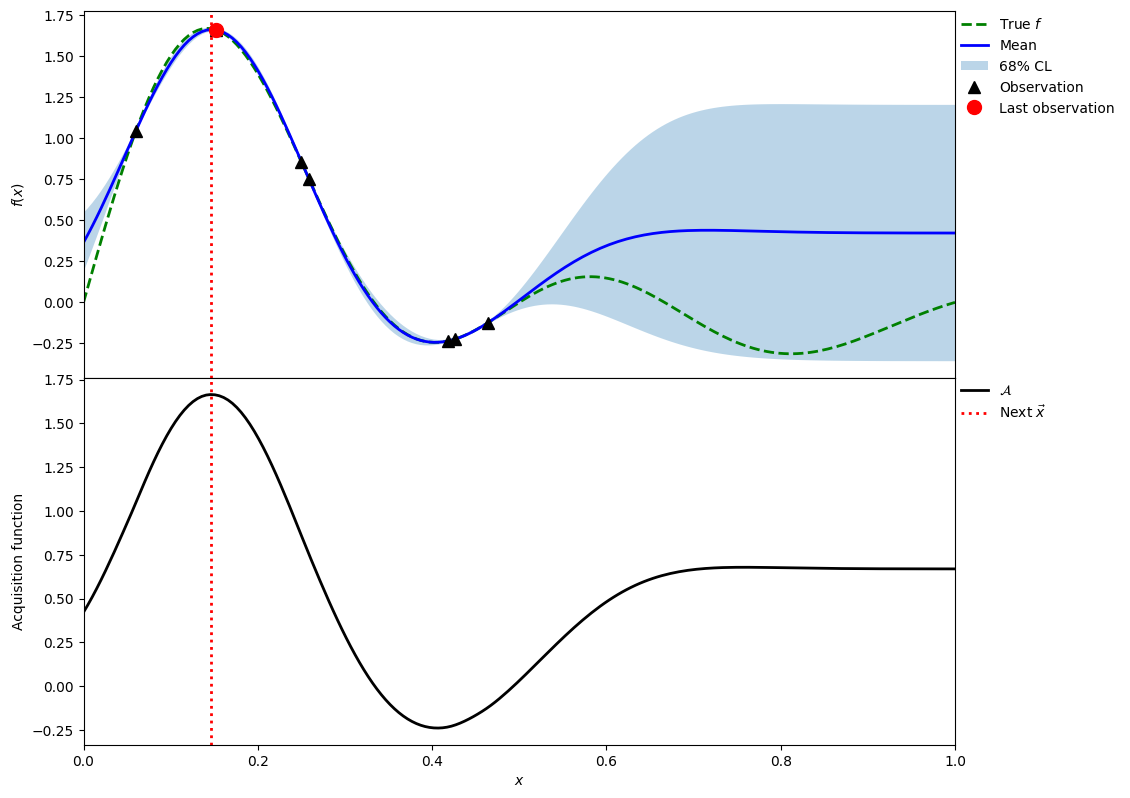

In [15]:
next_y = true_f(next_parameter)

x2 = torch.cat([x1, next_parameter], axis=0)
y2 = torch.cat([y1, next_y], axis=0)

next_parameter, model = update_params(x2, y2)

plot(x2, y2, model)